In [1]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
from print_color import print
import wandb
import torch._dynamo
torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision('high')


# Preprocessing

In [2]:
df = pd.read_csv('data/chessDataFinal.csv')[:30010]
df

,fen,score
0,5rk1/pb1pnppp/3Q2q1/b3P3/2B5/5N2/P4PPP/R4RK1 w...,+276
1,b1r5/3nk2p/R7/4p1p1/1PN1P3/2BP4/7P/6K1 w - - 8 59,+451
2,5k2/5p2/3p2p1/2p4q/p1P5/P3P2K/5QP1/3R4 w - - 1 34,-317
3,r5k1/pp2qrpp/4Pp2/2bp4/2p2P2/2Q5/PP4KP/nNB1R3 ...,-594
4,2nk3r/2p3pp/3p1p2/P2Q4/3P4/q4N2/4RKP1/8 w - - ...,+281
...,...,...
30005,8/p2r4/Pp2k3/1P3Rpp/6p1/3K2P1/7P/8 w - - 4 48,+23
30006,4R1r1/1q3p1k/p2B1p1p/2p2P2/2Pp4/PP5P/5Rb1/3Q2K...,+429
30007,r1bq1rk1/pp2npbp/2npp1p1/2p5/2P5/P1NP1NP1/1P2P...,+24
30008,rn1qk2r/pp3pp1/2pbpnp1/8/3P4/2P1B1N1/PP3PPP/R2...,-62


In [3]:
encoder_object = ChessEncoder()

In [4]:
fen_encodings = []
for fen_i in df['fen']:
    encoded_fen = encoder_object.encode_fen(fen_i)
    fen_encodings.append(encoded_fen)

In [5]:
X_train = torch.tensor(fen_encodings, dtype=torch.int32)

In [6]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y_train = torch.tensor(score_encodings, dtype=torch.float32)

In [7]:
X_train.shape, y_train.shape

(torch.Size([30010, 200]), torch.Size([30010]))

# Helper Functions

In [8]:
val_split = 10000
test_split = 10000

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
def get_batch(X, Y, bs):
    
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device).to(torch.float32)
    return x, y
# b = get_batch(X, y, 64)

In [11]:
X_val = X_train[:val_split].to(device)
y_val = y_train[:val_split].to(device)
X_test = X_train[val_split:val_split+test_split].to(device)
y_test = y_train[val_split:val_split+test_split].to(device)
X_train = X_train[val_split+test_split:]
y_train = y_train[val_split+test_split:]

# Training

In [ ]:
# hyperparameters
lr = 5e-2
num_steps = 500
warmup_steps = 30
bs_train = 10000
bs_validation = len(X_val) # don't change this
if bs_train > len(X_train): bs_train = len(X_train)
if bs_validation > len(X_train): bs_validation = len(X_train)

In [13]:
len(X_train), len(X_val)

(10010, 10000)

In [14]:
model = MLPEngine(embedding_dim=64, bs_train = bs_train, bs_eval=bs_validation).to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.AdamW(
            model.parameters(), 
            lr = lr,
            betas=(0.9, 0.999),
            eps=1e-3,
            weight_decay=1e-5)

# Define warm-up and decay
def lr_lambda(epoch):
    if epoch < warmup_steps:  
        return epoch / warmup_steps
    else:  # Exponential decay after warm-up
        return 0.99 ** (epoch - warmup_steps)

scheduler = LambdaLR(optimiser, lr_lambda)
model.compile()
train_history = {}
val_history = {}
start_step = 0

In [15]:
# if e
# run = wandb.init(project="chessAI")
# # run.config = {"epochs": num_steps, "learning_rate": lr}
# wandb.watch(model)

In [16]:
model.train()
for step_i in range(1, num_steps+1):
    tot_step = step_i + start_step
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X_train, y_train, bs_train) 
    # print(x_batch.shape, y_batch.shape)
    y_pred = model(x_batch).view(bs_train)
    loss = loss_category(y_pred, y_batch)
    train_history[tot_step] = loss.item()
    loss.backward()
    optimiser.step()
    scheduler.step()
    # wandb.log({"Training Loss": loss.item()})
    print(tot_step, ': ',loss.item())

    if tot_step % 100 == 0:
        # validation phase
        model.eval()
        y_pred = model(X_val).view(bs_validation)
        # print(X_val.shape, y_pred.shape)
        loss = loss_category(y_pred, y_val)
        val_history[tot_step] = loss.item()
        print(f'{tot_step}: {loss.item()} (Validation)', color='r')
        # wandb.log({"Validation Loss": loss.item()})
        model.train()


start_step += num_steps

1 :  3773829.0
2 :  3808593.5
3 :  3464052.75
4 :  3483315.25
5 :  3555078.0
6 :  3341420.25
7 :  3521860.25
8 :  3663977.5
9 :  3273047.5
10 :  3319461.75
11 :  3322428.5
12 :  3606287.0
13 :  3554004.0
14 :  3613184.0
15 :  3314952.5
16 :  3323704.0
17 :  3083755.0
18 :  3172055.25
19 :  3316366.75
20 :  3290191.0
21 :  3397156.25
22 :  3288605.75
23 :  3108852.75
24 :  3339840.75
25 :  3190891.0
26 :  3166343.5
27 :  2948865.5
28 :  3280490.75
29 :  3018690.0
30 :  2914480.75
31 :  3314755.5
32 :  2988835.0
33 :  2604864.75
34 :  2815401.75
35 :  2597606.25
36 :  2913638.0
37 :  2488358.0
38 :  2855817.5
39 :  2154749.0
40 :  2268375.75
41 :  2597502.5
42 :  2184856.0
43 :  2518850.0
44 :  2201898.25
45 :  2296036.5
46 :  2078137.875
47 :  1992094.625
48 :  1888810.5
49 :  1908190.625
50 :  1789821.875
51 :  1672402.75
52 :  1555316.0
53 :  1401853.0
54 :  1557876.25
55 :  1300920.125
56 :  1152759.625
57 :  988958.0625
58 :  1243690.125
59 :  1059151.375
60 :  1120600.5
61 :  10802

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'saves/model3.pt')

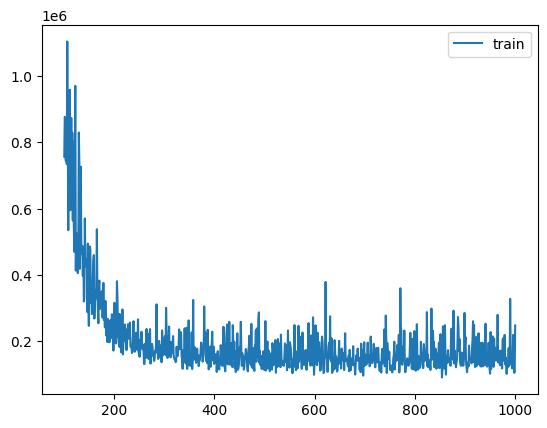

In [ ]:
plt.plot(list(train_history.keys())[100:], list(train_history.values())[100:], label='train')
# plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

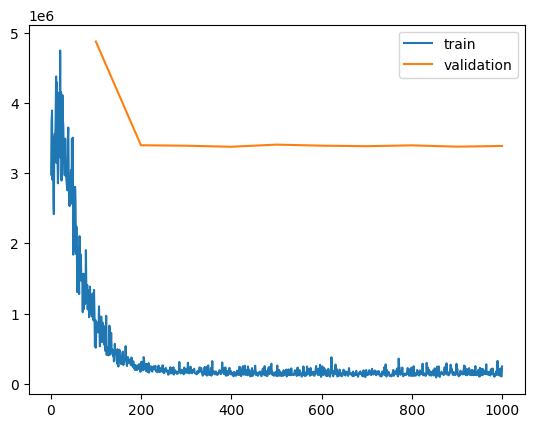

In [ ]:
plt.plot(list(train_history.keys()), list(train_history.values()), label='train')
plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

In [ ]:
'''
# My results
At relu, model is stuck around 25k with 3x1000 steps with xavier
AT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k
At gelu, model is stuck atound 10k

Adam is better than AdamW for this task
'''

'\n# My results\nAt relu, model is stuck around 25k with 3x1000 steps with xavier\nAT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k\nAt gelu, model is stuck atound 10k\n\nAdam is better than AdamW for this task\n'

# TO DO

- [x] do inference, and run a partially trained model with the GUI intact
- [x] **find a way to fix the fact that our model is giving integer loss
- [x] **Fix the bug in initialisation
- [ ] implement weights and biases or tensorboard 
- [ ] improve the model
  - [x] get a better/ bigger dataset
  - [ ] hyperparameter and architecture
    - [x] better encoding
    - [ ] residual connections
    - [ ] try adamW after tuning b1 and b2
    - [x] increase embedding dim
    - [x] increase neurons in the layers
    - [x] increase layers in the network
    - [x] change loss function (maybe)
    - [ ] try diff learning rate scheduler(trapeziodal)
    - [ ] Add regularisation
      - [ ] l1,l2
      - [x] dropout
    - [x] Better initialisation
    - [x] diff optimisation algorithm

# Note

My model is overfitting. What can i do?
- potential bug in val loss calculation
- regualisation
  - dropout
  - l1, l2
- make the model smaller, length and breadth
- 
- increase dataset, increase variety